In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.models import Model, load_model
from keras.layers import Flatten, Dense, LSTM, Dropout, Embedding, Activation
from keras.layers import concatenate, BatchNormalization, Input
from tensorflow.keras.layers import add
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import cv2
import random
import string
import glob
from keras.preprocessing.image import load_img, img_to_array
import pickle

In [ ]:
# Load descriptions from captions.txt
def load_descriptions(file_path):
    descriptions = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            tokens = line.strip().split(',', 1)  # Split into image and caption
            if len(tokens) < 2:
                continue  # Skip invalid lines
            img_id, caption = tokens
            img_id = os.path.splitext(img_id)[0]  # Remove file extension
            if img_id not in descriptions:
                descriptions[img_id] = []
            descriptions[img_id].append(caption)
    return descriptions

# Clean descriptions
def clean_description(desc):
    for key, des_list in desc.items():
        for i in range(len(des_list)):
            caption = des_list[i]
            caption = [ch for ch in caption if ch not in string.punctuation]
            caption = ''.join(caption)
            caption = caption.split(' ')
            caption = [word.lower() for word in caption if len(word) > 1 and word.isalpha()]
            caption = ' '.join(caption)
            des_list[i] = caption

# Filter descriptions for training images only
def load_clean_descriptions(descriptions, dataset_images):
    dataset_descriptions = {}
    for key, des_list in descriptions.items():
        if f"{key}.jpg" in dataset_images:  # Compare with `.jpg` filenames
            if key not in dataset_descriptions:
                dataset_descriptions[key] = []
            for line in des_list:
                desc = f"startseq {line} endseq"
                dataset_descriptions[key].append(desc)
    return dataset_descriptions

# Preprocess images for InceptionV3
def preprocess_img(img_path):
    img = load_img(img_path, target_size=(299, 299))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

# Encode images using InceptionV3
def encode(image, model):
    image = preprocess_img(image)
    vec = model.predict(image)
    vec = np.reshape(vec, (vec.shape[1]))
    return vec

# Save and load extracted features
def save_features(features, file_path):
    with open(file_path, 'wb') as f:
        pickle.dump(features, f)

def load_features(file_path):
    with open(file_path, 'rb') as f:
        return pickle.load(f)

# Initialize paths
captions_file = '/content/drive/MyDrive/ImageCaption/captions.txt'
images_dir = '/content/drive/MyDrive/ImageCaption/Images/'
features_file = '/content/drive/MyDrive/ImageCaption/encoded_features.pkl'
model_file = '/content/drive/MyDrive/ImageCaption/caption_model.h5'

# Load descriptions and clean them
descriptions = load_descriptions(captions_file)
clean_description(descriptions)

# List all image files
img_files = glob.glob(images_dir + '*.jpg')
img_names = [os.path.basename(img) for img in img_files]

# Reduce dataset size
dataset_percentage = 0.1
num_samples = int(len(img_names) * dataset_percentage)
img_names = random.sample(img_names, num_samples)

# Split into training, validation, and test sets
train_imgs, temp_imgs = train_test_split(img_names, test_size=0.3, random_state=42)
val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)

# Filter descriptions for training images only
train_descriptions = load_clean_descriptions(descriptions, train_imgs)

# Debug print to check the datasets being used
print(f"Training images: {len(train_imgs)}")
print(f"Training descriptions: {len(train_descriptions)}")


Training images: 566
Training descriptions: 566


In [ ]:


base_model = InceptionV3(weights='imagenet')
model_incep = Model(base_model.input, base_model.layers[-2].output)

# Extract features or load from file
features_file = '/content/drive/MyDrive/ImageCaption/features.pkl'  # Correct path for pickle file
if os.path.exists(features_file):
    print(f"Loading encoded features from {features_file}...")
    encoding_train = load_features(features_file)
else:
    encoding_train = {}
    for img in train_imgs:
        img_path = os.path.join(images_dir, img)
        print(f"Encoding image: {img_path}")
        encoding_train[img] = encode(img_path, model_incep)
    save_features(encoding_train, features_file)

# Debug print to check the keys in encoding_train
print(f"Encoding train contains {len(encoding_train)} keys")
print(f"Example key: {list(encoding_train.keys())[0]}")

# Collect all training captions into a single list
all_train_captions = []
for key, des_list in train_descriptions.items():
    for caption in des_list:
        all_train_captions.append(caption)

# Define the vocabulary
threshold = 5
word_counts = {}
for caption in all_train_captions:
    for word in caption.split(' '):
        word_counts[word] = word_counts.get(word, 0) + 1

vocab = [word for word in word_counts if word_counts[word] >= threshold]
ixtoword = {}
wordtoix = {}

ix = 1
for word in vocab:
    wordtoix[word] = ix
    ixtoword[ix] = word
    ix += 1

# Find the maximum length of a description
max_length = max(len(des.split()) for des in all_train_captions)

# Prepare data for training
X1, X2, y = [], [], []
for key, des_list in train_descriptions.items():
    img_key = f"{key}.jpg"
    if img_key not in encoding_train:  # Handle missing image features
        print(f"Missing image feature for {img_key}, skipping.")
        continue
    pic = encoding_train[img_key]

    for cap in des_list:
        seq = [wordtoix[word] for word in cap.split(' ') if word in wordtoix]
        for i in range(1, len(seq)):
            in_seq, out_seq = seq[:i], seq[i]
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            out_seq = to_categorical([out_seq], num_classes=len(vocab) + 1)[0]
            X1.append(pic)
            X2.append(in_seq)
            y.append(out_seq)

X1, X2, y = np.array(X1), np.array(X2), np.array(y)

# Debug print to check the shapes of X1, X2, and y
print(f"X1 shape: {X1.shape}")
print(f"X2 shape: {X2.shape}")
print(f"y shape: {y.shape}")

# Load or create model
model_file = '/content/drive/MyDrive/ImageCaption/model.h5'  # Correct path for .h5 model file
if os.path.exists(model_file):
    model = load_model(model_file)
else:
    # Initialize embeddings index
    embeddings_index = {}
    emb_dim = 200
    emb_matrix = np.zeros((len(vocab) + 1, emb_dim))
    glove_path = '/content/drive/MyDrive/ImageCaption/glove.6B.200d.txt'
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    for word, i in wordtoix.items():
        emb_vec = embeddings_index.get(word)
        if emb_vec is not None:
            emb_matrix[i] = emb_vec

    ip1 = Input(shape=(2048,))
    fe1 = Dropout(0.2)(ip1)
    fe2 = Dense(256, activation='relu')(fe1)

    ip2 = Input(shape=(max_length,))
    se1 = Embedding(len(vocab) + 1, emb_dim, mask_zero=True)(ip2)
    se2 = Dropout(0.2)(se1)
    se3 = LSTM(256)(se2)

    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(len(vocab) + 1, activation='softmax')(decoder2)

    model = Model(inputs=[ip1, ip2], outputs=outputs)
    model.layers[2].set_weights([emb_matrix])
    model.layers[2].trainable = False
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    model.fit([X1, X2], y, epochs=50, batch_size=64)
    model.save(model_file)


Encoding image: /content/drive/MyDrive/ImageCaption/Images/1937262236_cbf5bfa101.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Encoding image: /content/drive/MyDrive/ImageCaption/Images/2151056407_c9c09b0a02.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
Encoding image: /content/drive/MyDrive/ImageCaption/Images/3368865171_597d51cdd5.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
Encoding image: /content/drive/MyDrive/ImageCaption/Images/527272653_8a5bd818e5.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
Encoding image: /content/drive/MyDrive/ImageCaption/Images/3339747039_1a8455c210.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
Encoding image: /content/drive/MyDrive/ImageCaption/Images/440184957_267f3f3a2b.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
Encoding image: /content/drive/MyDrive/ImageCaption/Images/3227140905_1d7e30e4c4.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
Encoding image: /content/drive/MyDrive/ImageCaption/Images/2269021076_cefc9af989.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
Encoding imag

['1937262236_cbf5bfa101.jpg', '2151056407_c9c09b0a02.jpg', '3368865171_597d51cdd5.jpg', '527272653_8a5bd818e5.jpg', '3339747039_1a8455c210.jpg', '440184957_267f3f3a2b.jpg', '3227140905_1d7e30e4c4.jpg', '2269021076_cefc9af989.jpg', '380515798_c2abbf46b0.jpg', '432490118_54a9c0e500.jpg', '421808539_57abee6d55.jpg', '3021318991_fa28e3bca7.jpg', '293879742_5fe0ffd894.jpg', '3568197730_a071d7595b.jpg', '1797554350_20998753c0.jpg', '3116985493_04b1dc3345.jpg', '381239475_044cbffa2b.jpg', '2330062180_355ccbceb5.jpg', '2472720629_d9a6736356.jpg', '3324056835_84904fe2f8.jpg', '3415646718_f9f4e23a66.jpg', '3085973779_29f44fbdaa.jpg', '3106223494_52d4d2d75d.jpg', '2732625904_4fbb653434.jpg', '523985664_c866af4850.jpg', '3474330484_a01d8af624.jpg', '2695961935_a2a6338f26.jpg', '3472703856_568d9778b5.jpg', '2950637275_98f1e30cca.jpg', '2276499757_b44dc6f8ce.jpg', '448252603_7d928c900e.jpg', '2911245290_b2c79f328a.jpg', '3036641436_d6594fc45f.jpg', '3432634159_1eb9a73306.jpg', '2415803492_56a673dc25

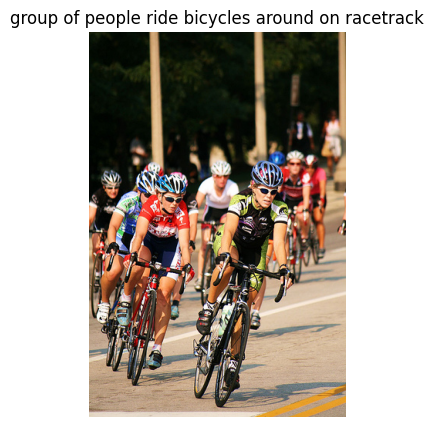

In [ ]:
# Load the pre-saved features from the pickle file
with open('/content/drive/MyDrive/ImageCaption/features.pkl', 'rb') as f:
    features_dict = pickle.load(f)

# Print all available image filenames in the pickle file
print(list(features_dict.keys()))

# Define the greedy search function
def greedy_search(pic, model, wordtoix, ixtoword, max_length=34):  # Updated max_length to 34
    start = 'startseq'
    for i in range(max_length):
        # Convert the sequence of words to their corresponding indices
        seq = [wordtoix[word] for word in start.split() if word in wordtoix]
        seq = pad_sequences([seq], maxlen=max_length)

        # Ensure pic has the correct shape: (1, 2048)
        pic = np.reshape(pic, (1, 2048))  # Reshape to (1, 2048)

        # Print the shapes of the inputs before prediction
        print(f"Image Features shape: {pic.shape}")
        print(f"Sequence shape: {seq.shape}")

        # Get the prediction from the model
        try:
            yhat = model.predict([pic, seq])  # Pass both inputs together
        except ValueError as e:
            print(f"Error during prediction: {e}")
            return None

        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        start += ' ' + word
        if word == 'endseq':
            break

    final = start.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final


#image_filename = '1937262236_cbf5bfa101.jpg'
#image_filename = '3368865171_597d51cdd5.jpg'
image_filename = '2708176152_1634cb754d.jpg'


img_features = features_dict.get(image_filename)


if img_features is None:
    print(f"Features for {image_filename} not found.")
else:
    # Ensure that img_features has the correct shape (1, 2048)
    img_features = np.reshape(img_features, (1, 2048))  # Reshape to (1, 2048) if it's not in this shape already

    # Generate the caption using the extracted features
    caption = greedy_search(img_features, model, wordtoix, ixtoword)

    if caption is not None:
        # Load the image for display
        image_path = f'/content/drive/MyDrive/ImageCaption/Images/{image_filename}'
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for displaying with Matplotlib

        # Display the image with its generated caption
        plt.figure(figsize=(5, 5))
        plt.imshow(img)
        plt.title(caption)
        plt.axis('off')
        plt.show()
    else:
        print("Caption generation failed.")